<a href="https://colab.research.google.com/github/Biboubap/evolution/blob/master/moo/NSGA-II-EnClasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/d9w/evolution/raw/master/imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Algorithms

## NSGA-II

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://d9w.github.io/evolution/</a>

To explore NSGA-II, we'll use the [PyMOO](https://pymoo.org/algorithms/nsga2.html) library and a Multi-Objective Travelling Salesman Problem. For the different objectives, we'll construct random distance matrices, but we could imagine, for example, that one objective is travel time between two points and a second objective is travel cost. We want to minimize both objectives, choosing a route from the Pareto front of quick and low-cost travel.

In [30]:
!pip install pymoo

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

First, we define the Multi-Objective Travelling Salesman Problem using the `ElementwiseProblem` class from `pymoo`. We'll define it to take any number of cities and objectives, returning a fitness of the total distance from each objective for the given individual. We specify a constraint on the order to ensure we're visiting each city once, but we'll also define the same operators as in the GA notebook to make sure all individuals meet this constraint.

In [32]:
from pymoo.core.problem import ElementwiseProblem

class MOTSP(ElementwiseProblem):

    def __init__(self, n_cities, n_obj):
        # lower bound
        xl = np.zeros(n_cities)
        # upper bound
        xu = (n_cities-1) * np.ones(n_cities)

        self.n_cities = n_cities
        self.distances = []
        for i in range(n_obj):
            # random symmetric matrix
            d = np.random.rand(n_cities, n_cities)
            d = np.tril(d) + np.tril(d, -1).T
            d[np.diag_indices(n_cities)] = 0
            self.distances.append(d)

        super().__init__(n_var=n_cities, n_obj=n_obj, n_constr=1,
                        xl=xl, xu=xu)

    def total_distance(self, x, d):
        t = 0
        for i in range(1, len(x)):
            t += self.distances[d][x[i-1], x[i]]
        return t

    def _evaluate(self, x, out, *args, **kwargs):
        # fitness based on each distance matrix
        fits = np.zeros(len(self.distances))
        for i in range(len(self.distances)):
            fits[i] = self.total_distance(x, i)

        # constraints return negative if met
        c = -np.sum(np.arange(self.n_cities) != np.sort(x))

        # return by modifying out
        out["F"] = np.column_stack(fits)
        out["G"] = np.array([c])

Next, we define NSGA2, its hyperparameters and operators. We'll use the same operators as before. Note that `pymoo` allows for generating fewer offspring than the initial population size and that it can check for duplicates. We'll use this second feature.

In [33]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.erx import EdgeRecombinationCrossover
from pymoo.operators.sampling.rnd import PermutationRandomSampling
from pymoo.operators.mutation.inversion import InversionMutation

algorithm = NSGA2(
    pop_size=100,
    n_offsprings=100,
    sampling=PermutationRandomSampling(),
    crossover=EdgeRecombinationCrossover(),
    mutation=InversionMutation(),
    eliminate_duplicates=True
)

To start, let's define a 20-city problem with 2 objectives. As mentioned, these could be total travel time and total travel cost. We want to minimize both objectives. Note the use of `seed=1` in the call to `minimize`: this optimization is deterministic (we can run it multiple times and get the same result).

In [34]:
from pymoo.optimize import minimize

problem = MOTSP(20, 2)
res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |      6 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |      5 |  0.000000E+00 |  0.000000E+00 |  0.2634001334 |         ideal
     3 |      300 |      6 |  0.000000E+00 |  0.000000E+00 |  0.1505145984 |         ideal
     4 |      400 |      9 |  0.000000E+00 |  0.000000E+00 |  0.1293140253 |         ideal
     5 |      500 |      9 |  0.000000E+00 |  0.000000E+00 |  0.2417067512 |         ideal
     6 |      600 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0404291851 |         ideal
     7 |      700 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0605902416 |         ideal
     8 |      800 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0234099389 |             f
     9 |      900 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0246490991 |             f
    10 |     1000 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0204860759 |         ideal

The `res` object returned from the search contains the results, including the final Pareto front.

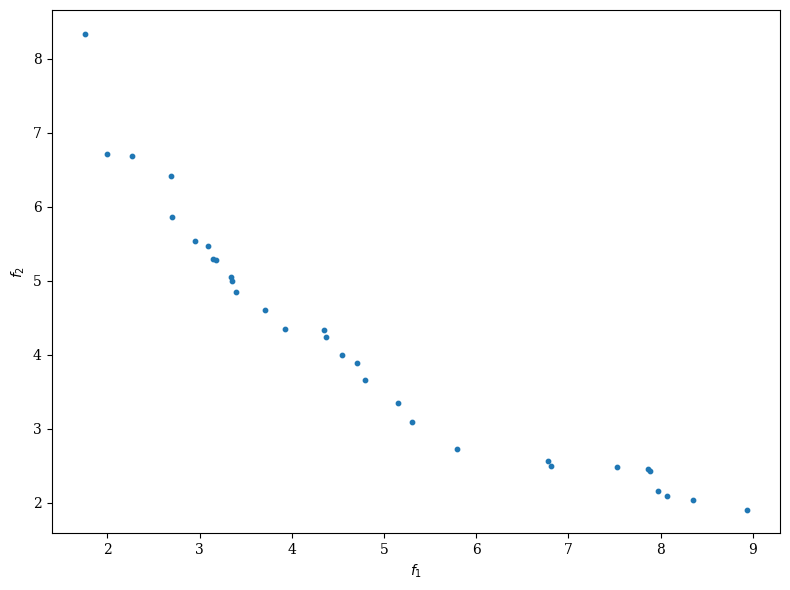

In [35]:
from pymoo.visualization.scatter import Scatter
plot = Scatter(tight_layout=True)
plot.add(res.F, s=10)
plot.show();

<div class="alert alert-success">
    <h3>Exercise 1</h3>

Look at the [visualization](http://pymoo.org/visualization/index.html) options in pymoo and visualize the population. What plot makes most sense to you to present the full population of possible solutions? What about presenting a single solution? What about when the number of objectives increases, ie to 5?
</div>

We can also visualize the convergence of each objective. We'll plot the fitness of the first individual in the Pareto front over evolution. Note that this isn't the best value for each objective independently, but rather the objective values of a single individual.

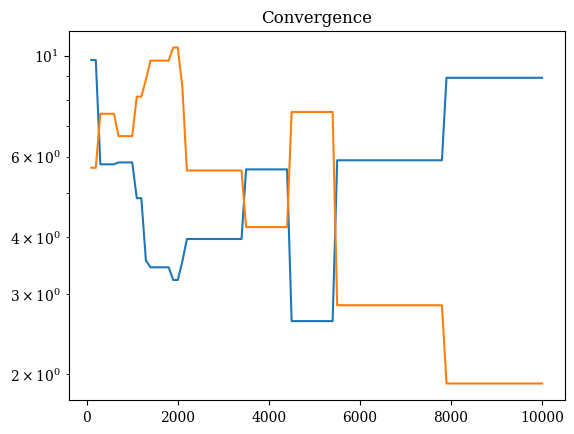

In [36]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

plt.title("Convergence")
plt.plot(n_evals, opt)
plt.yscale("log")
plt.show()

As the number of dimensions grows, visualizing the convergence across all objectives becomes difficult. One recently proposed metric known as the "running metric" evaluates non-dominated sets from each generation relative to previously recorded sets. This gives an idea of how much the Pareto front has moved in any generation. For visualizing this running metric, each ND set is normalized by the final ND set after a certain number of generations. The difference between intervals then gives an idea if the algorithm is converging.

<img src="https://github.com/d9w/evolution/raw/master/imgs/running_metric.png">

Blank, Julian, and Kalyanmoy Deb. "A running performance metric and termination criterion for evaluating evolutionary multi-and many-objective optimization algorithms." Proc. IEEE World Congr. Comput. Intell.(WCCI). 2020.

https://www.egr.msu.edu/~kdeb/papers/c2020003.pdf

In [37]:
from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(delta_gen=20,
                        n_plots=5,
                        key_press=False,
                        do_show=True)



<div class="alert alert-success">
    <h3>Exercise 2</h3>

Increase the number of objectives and observe the convergence of NSGA-II. Roughly, how much does each objective change convergence speed?
</div>

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      100 |     51 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      200 |     79 |  0.000000E+00 |  0.000000E+00 |  0.0398828487 |         ideal
     3 |      300 |    100 |  0.000000E+00 |  0.000000E+00 |  0.1229279168 |         ideal
     4 |      400 |    100 |  0.000000E+00 |  0.000000E+00 |  0.1218362121 |         ideal
     5 |      500 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0400200266 |         ideal
     6 |      600 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0175007534 |         ideal
     7 |      700 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0298204332 |         ideal
     8 |      800 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0161241726 |         ideal
     9 |      900 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0262907087 |         ideal
    10 |     1000 |    100 |  0.000000E+00 |  0.000000E+00 |  0.0564600470 |         ideal

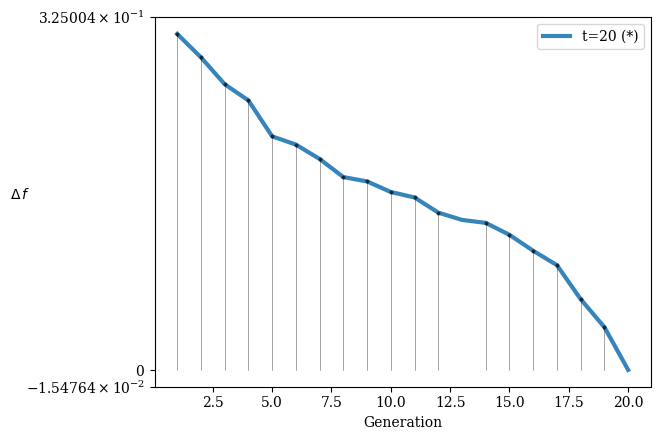

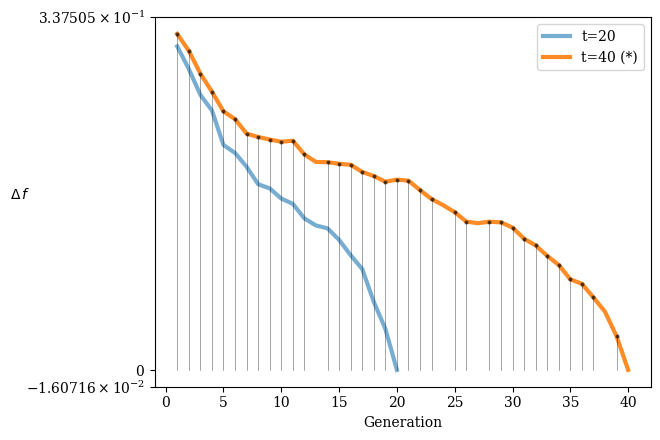

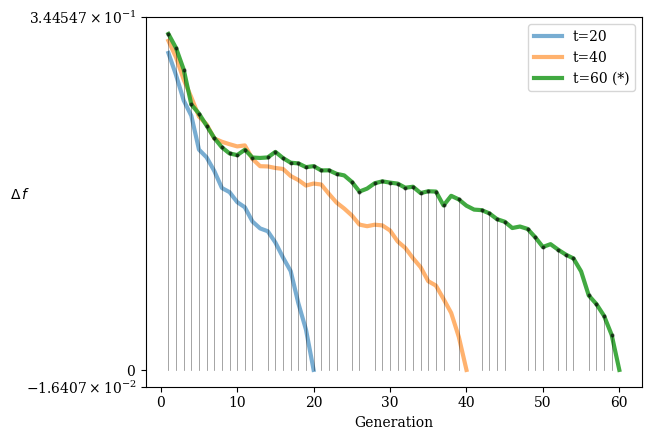

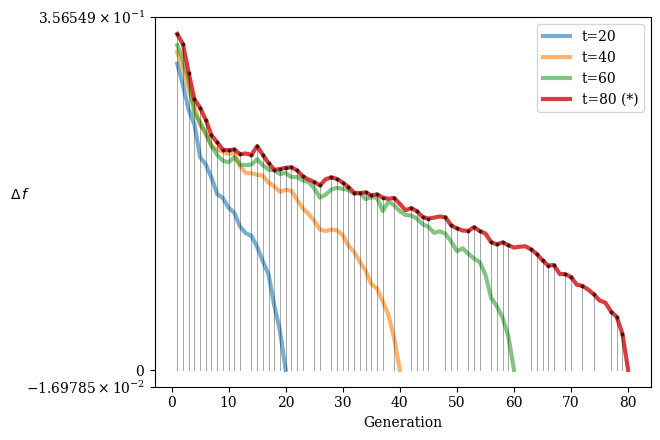

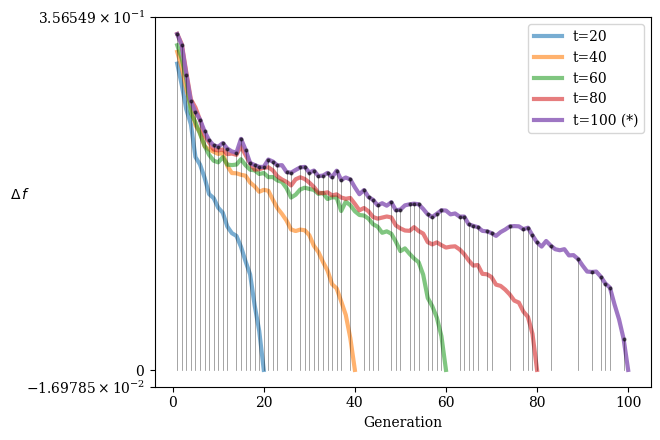

In [38]:
problem = MOTSP(20, 5) #2à villes 4 objectifs
res = minimize(problem,
               algorithm,
               ("n_gen", 100),
               seed=1,
               save_history=True,
               verbose=True)

from pymoo.util.running_metric import RunningMetricAnimation

running = RunningMetricAnimation(delta_gen=20,
                        n_plots=5,
                        key_press=False,
                        do_show=True)

for algorithm in res.history:
    running.update(algorithm)